In [1]:
%matplotlib inline
import numpy as np
import pandas
from ggplot import *
import matplotlib.pyplot as plt
from scipy.stats import probplot

In [2]:
turnstile_weather = pandas.read_csv('improved-dataset/turnstile_weather_v2.csv')

In [3]:
turnstile_weather['overcast'] = turnstile_weather['conds']=='Overcast'
turnstile_weather['clear'] = turnstile_weather['conds']=='Clear'

In [4]:

"""
In this question, you need to:
1) implement the compute_cost() and gradient_descent() procedures
2) Select features (in the predictions procedure) and make predictions.

"""

def normalize_features(df):
    """
    Normalize the features in the data set.
    """
    mu = df.mean()
    sigma = df.std()
    
    if (sigma == 0).any():
        raise Exception("One or more features had the same value for all samples, and thus could " + \
                         "not be normalized. Please do not include features with only a single value " + \
                         "in your model.")
    df_normalized = (df - df.mean()) / df.std()

    return df_normalized, mu, sigma

def compute_cost(features, values, theta):
    """
    Compute the cost function given a set of features / values, 
    and the values for our thetas.
    
    This can be the same code as the compute_cost function in the lesson #3 exercises,
    but feel free to implement your own.
    """
    
    predictions = np.dot(features, theta)
    
    cost = np.mean(np.square(values-predictions))/2

    return cost

def gradient_descent(features, values, theta, alpha, num_iterations):
    """
    Perform gradient descent given a data set with an arbitrary number of features.
    
    This can be the same gradient descent code as in the lesson #3 exercises,
    but feel free to implement your own.
    """
    
    m = len(values)
    cost_history = []

    for i in range(num_iterations):
        cost_history.append(compute_cost(features, values, theta))
        
        predictions = np.dot(features, theta)
        
        grad = -np.dot(features.T, (values - predictions))/m
        theta -= alpha*grad
        
    return theta, pandas.Series(cost_history)

def ols(features, values):
    import statsmodels.api as sm
    model = sm.OLS(values, features)
    results = model.fit()
    print results.summary()
    return results.params, None
    
def predictions(dataframe,feature_names=['clear','hour','weekday'],use_ols=True):
    '''
    The NYC turnstile data is stored in a pandas dataframe called weather_turnstile.
    Using the information stored in the dataframe, let's predict the ridership of
    the NYC subway using linear regression with gradient descent.
    
    You can download the complete turnstile weather dataframe here:
    https://www.dropbox.com/s/meyki2wl9xfa7yk/turnstile_data_master_with_weather.csv    
    
    Your prediction should have a R^2 value of 0.40 or better.
    You need to experiment using various input features contained in the dataframe. 
    We recommend that you don't use the EXITSn_hourly feature as an input to the 
    linear model because we cannot use it as a predictor: we cannot use exits 
    counts as a way to predict entry counts. 
    
    Note: Due to the memory and CPU limitation of our Amazon EC2 instance, we will
    give you a random subet (~15%) of the data contained in 
    turnstile_data_master_with_weather.csv. You are encouraged to experiment with 
    this computer on your own computer, locally. 
    
    
    If you'd like to view a plot of your cost history, uncomment the call to 
    plot_cost_history below. The slowdown from plotting is significant, so if you 
    are timing out, the first thing to do is to comment out the plot command again.
    
    If you receive a "server has encountered an error" message, that means you are 
    hitting the 30-second limit that's placed on running your program. Try using a 
    smaller number for num_iterations if that's the case.
    
    If you are using your own algorithm/models, see if you can optimize your code so 
    that it runs faster.
    '''
    # Select Features (try different features!)
    features = dataframe[feature_names]

    
    # Add UNIT to features using dummy variables
    dummy_units = pandas.get_dummies(dataframe['UNIT'], prefix='unit')
    features = features.join(dummy_units)
    
    # Values
    values = dataframe['ENTRIESn_hourly']
    m = len(values)

    features, mu, sigma = normalize_features(features)
    features['ones'] = np.ones(m) # Add a column of 1s (y intercept)

    # Convert features and values to numpy arrays
    features_array = np.array(features)
    values_array = np.array(values)
    
    if use_ols:
        theta, cost_history = ols(features_array, values_array)
    else:
        # Set values for alpha, number of iterations.
        alpha = 0.1 # please feel free to change this value
        num_iterations = 75 # please feel free to change this value

    #     Initialize theta, perform gradient descent
        theta = np.zeros(len(features.columns))

        theta, cost_history = gradient_descent(features_array, 
                                                values_array, 
                                                theta, 
                                                alpha, 
                                                num_iterations)
    
    predictions = np.dot(features_array, theta)
    return predictions, theta, cost_history


def plot_cost_history(alpha, cost_history):
   """This function is for viewing the plot of your cost history.
   You can run it by uncommenting this

       plot_cost_history(alpha, cost_history) 

   call in predictions.
   
   If you want to run this locally, you should print the return value
   from this function.
   """
   cost_df = pandas.DataFrame({
      'Cost_History': cost_history,
      'Iteration': range(len(cost_history))
   })
   return ggplot(cost_df, aes('Iteration', 'Cost_History')) + \
      geom_point() + ggtitle('Cost History for alpha = %.3f' % alpha )




def plot_residuals(turnstile_weather, predictions):
    '''
    Using the same methods that we used to plot a histogram of entries
    per hour for our data, why don't you make a histogram of the residuals
    (that is, the difference between the original hourly entry data and the predicted values).
    Try different binwidths for your histogram.

    Based on this residual histogram, do you have any insight into how our model
    performed?  Reading a bit on this webpage might be useful:

    http://www.itl.nist.gov/div898/handbook/pri/section2/pri24.htm
    '''
    
    plot = (turnstile_weather['ENTRIESn_hourly'] - predictions).hist(bins=100)

def compute_r_squared(data, predictions):
    '''
    In exercise 5, we calculated the R^2 value for you. But why don't you try and
    and calculate the R^2 value yourself.
    
    Given a list of original data points, and also a list of predicted data points,
    write a function that will compute and return the coefficient of determination (R^2)
    for this data.  numpy.mean() and numpy.sum() might both be useful here, but
    not necessary.

    Documentation about numpy.mean() and numpy.sum() below:
    http://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html
    http://docs.scipy.org/doc/numpy/reference/generated/numpy.sum.html
    '''
    mean = np.mean(data)
    sum_squared_total = np.sum(np.square(mean - data))
#     sum_squared_regression = np.sum(np.square(mean - predictions))
    sum_squared_residuals = np.sum(np.square(data - predictions))
    
    r_squared = (sum_squared_residuals/sum_squared_total)
    
    return r_squared

In [42]:
features_start = set(turnstile_weather.columns) - set(('ENTRIESn', 'ENTRIESn_hourly', 'EXITSn', 'EXITSn_hourly', 'datetime', 'station', 'conds',  'UNIT', 'DATEn', 'TIMEn'))
feats = list(features_start)
pred, plot, _ = predictions(turnstile_weather, feats, False)
r = compute_r_squared(turnstile_weather['ENTRIESn_hourly'], pred)

print r
for feat in feats:
    feats = features_start - set((feat,))
    pred, plot, _ = predictions(turnstile_weather, list(feats), False)
    new_r = compute_r_squared(turnstile_weather['ENTRIESn_hourly'], pred)
    if r-new_r<0.001:
        features_start = feats
        print 'removing', feat
        print new_r

In [5]:
feats = ['clear', 'weekday', 'hour', 'wspdi', 'meanwspdi', 'tempi', 'meantempi', 'precipi', 'meanprecipi']

In [6]:
pred, _, _ = predictions(turnstile_weather, list(feats))


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     163.4
Date:                Tue, 04 Aug 2015   Prob (F-statistic):               0.00
Time:                        10:45:57   Log-Likelihood:            -3.8699e+05
No. Observations:               42649   AIC:                         7.745e+05
Df Residuals:                   42400   BIC:                         7.766e+05
Df Model:                         248                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            98.0619     14.872      6.594      0.0

In [7]:
turnstile_weather['pred'] = pred
turnstile_weather['residuals_model'] = turnstile_weather['ENTRIESn_hourly'] - pred


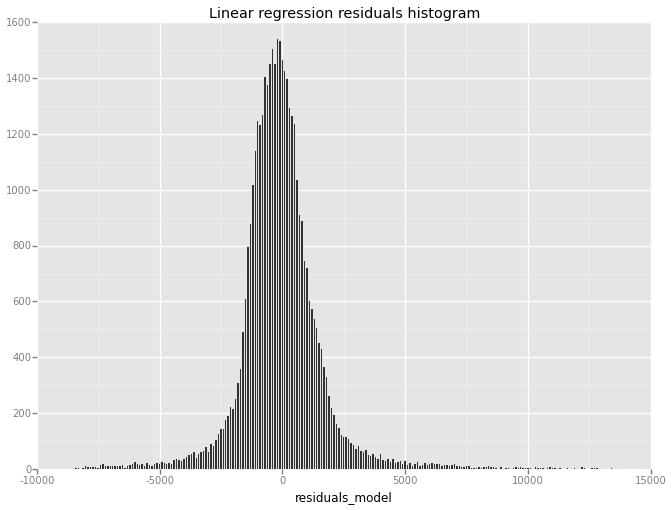

<ggplot: (276155533)>


Saving 11.0 x 8.0 in image.


In [7]:
plot = ggplot(aes(x='residuals_model'), data=turnstile_weather) +\
        geom_histogram(binwidth=100) +\
        ggtitle('Linear regression residuals histogram') + xlim(high=15000)
print plot
ggsave('residuals-histogram.png', plot)


Saving 11.0 x 8.0 in image.


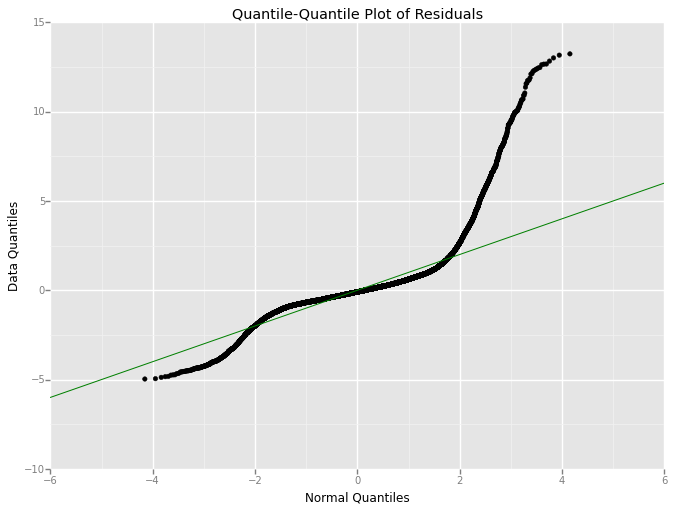

<ggplot: (288006209)>


In [20]:
(osm, osr),(slope, intercept, r) = probplot(turnstile_weather['residuals_model'])
df = pandas.DataFrame({'Normal Quantiles' : osm, 'Data Quantiles' : osr/slope})
plot = ggplot(aes(x='Normal Quantiles', y='Data Quantiles'), data=df) +\
        geom_point() +\
        geom_abline(slope=1, intercept=0,color='green') +\
        ggtitle('Quantile-Quantile Plot of Residuals')
ggsave('qqplot-residuals-norm.png', plot)
print plot

Saving 11.0 x 8.0 in image.


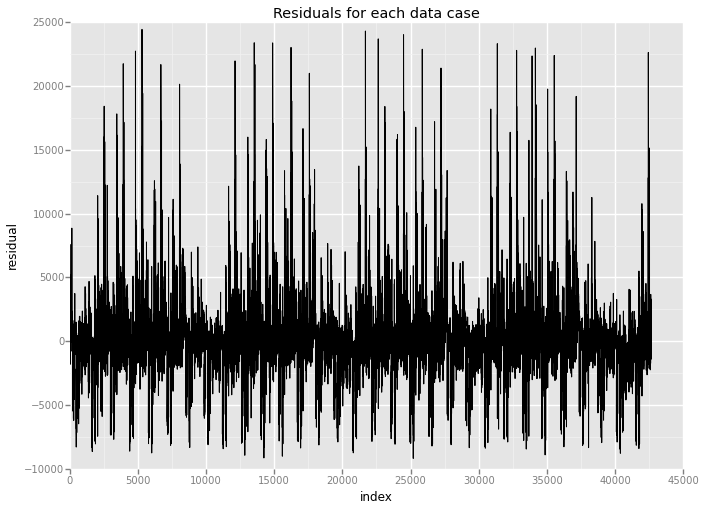

<ggplot: (280938977)>


In [58]:
data = pandas.DataFrame({'index': range(len(turnstile_weather)), 
                         'residual': turnstile_weather.sort(['DATEn', 'hour','UNIT'])['residuals_model']})
plot = ggplot(aes(x='index', y='residual'), data=data) + geom_line() + ggtitle('Residuals for each data case')
ggsave('residuals-by-case.png', plot)
print plot


Saving 11.0 x 8.0 in image.


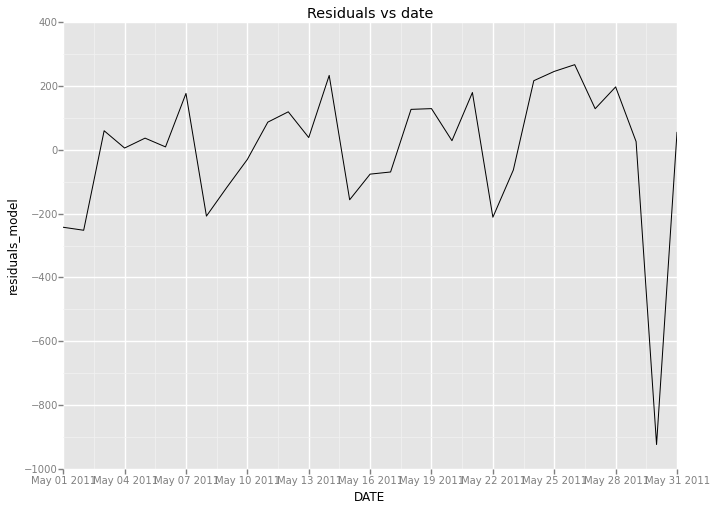

<ggplot: (281270489)>


In [51]:
turnstile_weather['DATE'] = pandas.to_datetime(turnstile_weather['DATEn'])
data = turnstile_weather.groupby('DATE', as_index=False)['residuals_model'].mean()
plot = ggplot(aes(x='DATE',y='residuals_model'), data=data) + geom_line() + ggtitle('Residuals vs date')
ggsave('res-vs-date.png', plot)
print plot

Saving 11.0 x 8.0 in image.


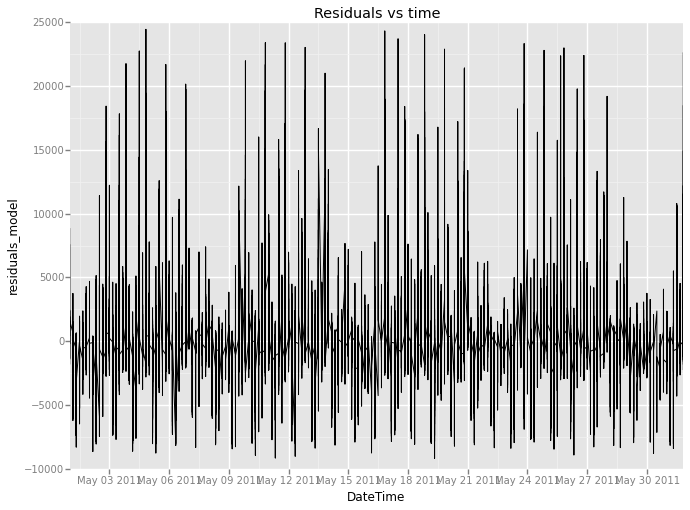

<ggplot: (281844121)>


In [60]:
turnstile_weather['DateTime'] = pandas.to_datetime(turnstile_weather['datetime'])
# data = turnstile_weather.groupby('DateTime', as_index=False)['residuals_model'].mean()
plot = ggplot(aes(x='DateTime',y='residuals_model'), data=turnstile_weather) +\
        geom_line() +\
        ggtitle('Residuals vs time')
ggsave('res-vs-time.png', plot)
print plot

Saving 11.0 x 8.0 in image.


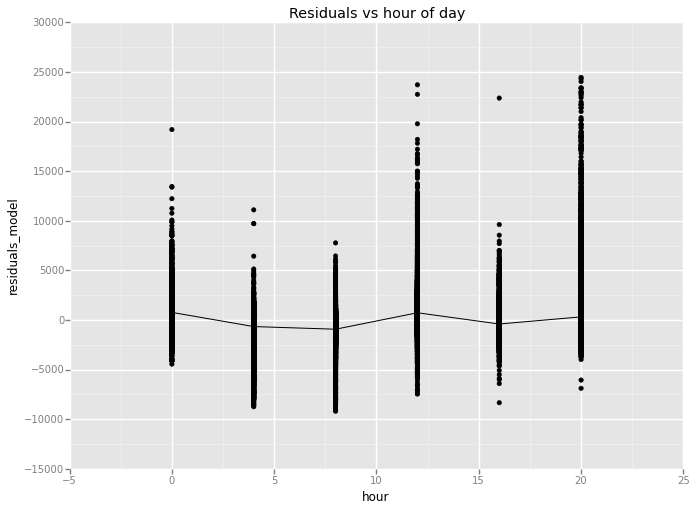

<ggplot: (281254545)>


In [40]:
data = turnstile_weather.groupby('hour', as_index=False)['residuals_model'].mean()
plot = ggplot(aes(x='hour',y='residuals_model'), data=turnstile_weather) +\
        geom_point() +\
        geom_line(data=data) +\
        ggtitle('Residuals vs hour of day')
ggsave('res-vs-time.png', plot)
print plot

In [ ]:
turnstile_weather.groupby('UNIT').count

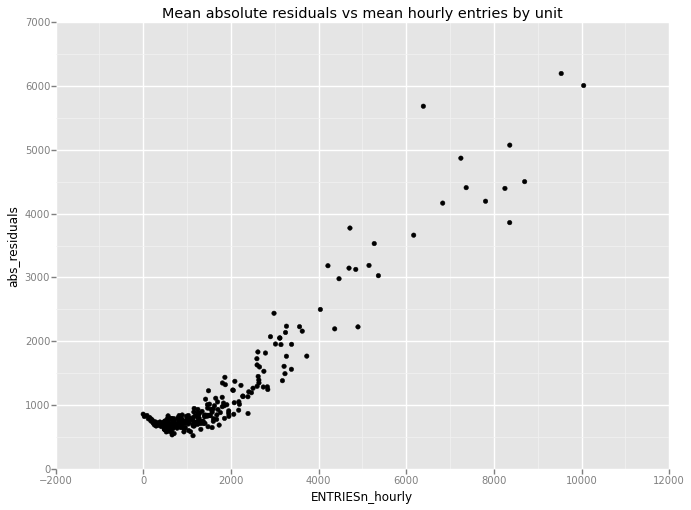

<ggplot: (296056921)>


Saving 11.0 x 8.0 in image.


In [97]:
turnstile_weather['abs_residuals'] = turnstile_weather['residuals_model'].abs()
new = turnstile_weather.groupby('UNIT', as_index=False).mean()
plot = ggplot(aes(x='ENTRIESn_hourly',y='abs_residuals'), data=new) +\
        geom_point() + \
        ggtitle('Mean absolute residuals vs mean hourly entries by unit')
print plot
ggsave('residuals-by-unit.png', plot)


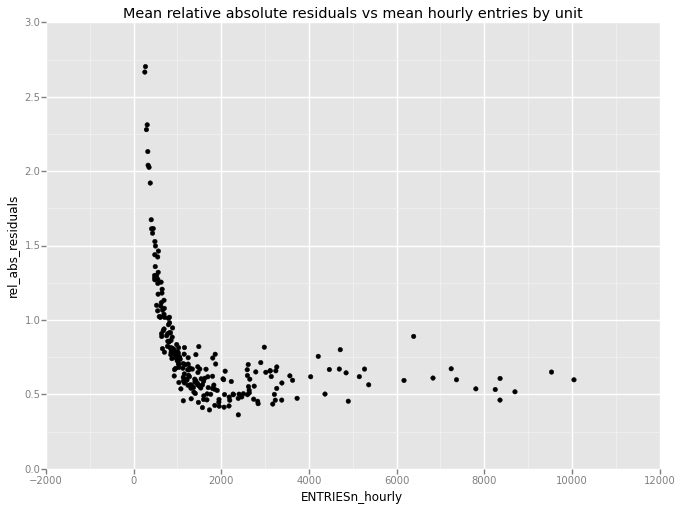

<ggplot: (289562805)>


Saving 11.0 x 8.0 in image.


In [104]:
new['rel_abs_residuals'] = new['abs_residuals']/new['ENTRIESn_hourly']
plot = ggplot(aes(x='ENTRIESn_hourly',y='rel_abs_residuals'), data=new) +\
        geom_point() + \
        ylim(low=0,high=3) +\
        ggtitle('Mean relative absolute residuals vs mean hourly entries by unit')
print plot
ggsave('rel-residuals-by-unit.png', plot)



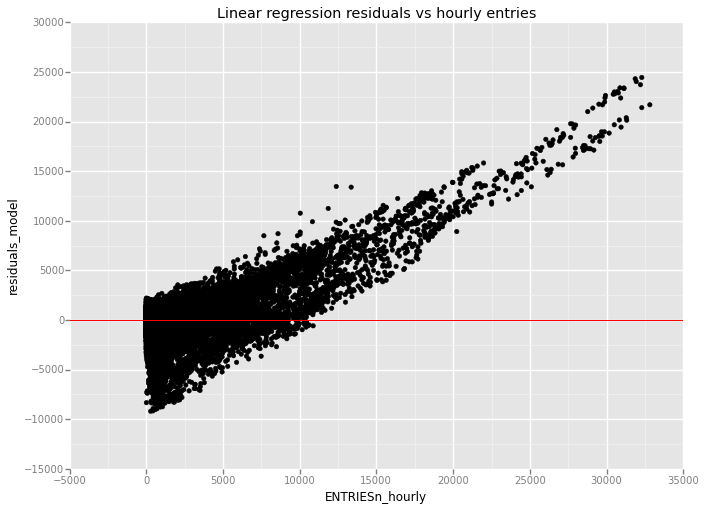

<ggplot: (289092501)>


In [54]:
plot =  ggplot(aes(x='ENTRIESn_hourly',y='residuals_model'),data=turnstile_weather) + \
            geom_point() + \
            geom_abline(intercept=0, slope=0, color='red') +\
            ggtitle('Linear regression residuals vs hourly entries')
print plot

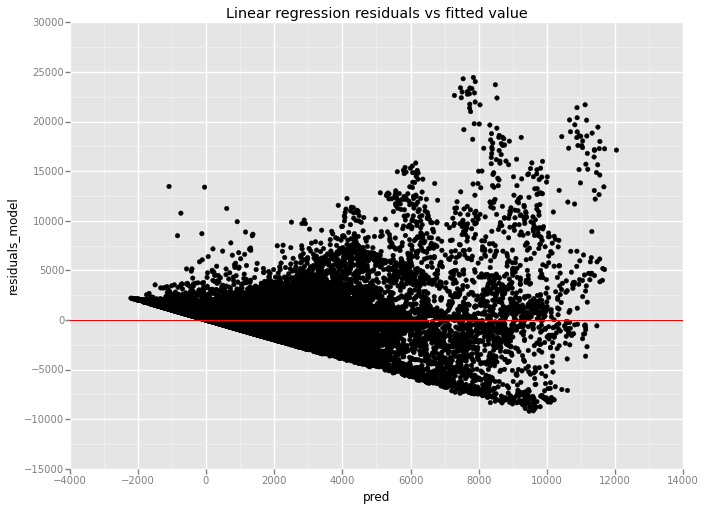

<ggplot: (289316305)>


Saving 11.0 x 8.0 in image.


In [56]:
plot =  ggplot(aes(x='pred',y='residuals_model'),data=turnstile_weather) +\
            geom_point() +\
            geom_abline(intercept=0, slope=0, color='red') +\
            ggtitle('Linear regression residuals vs fitted value')
print plot
ggsave('residuals-vs-pred.png', plot)

Saving 11.0 x 8.0 in image.


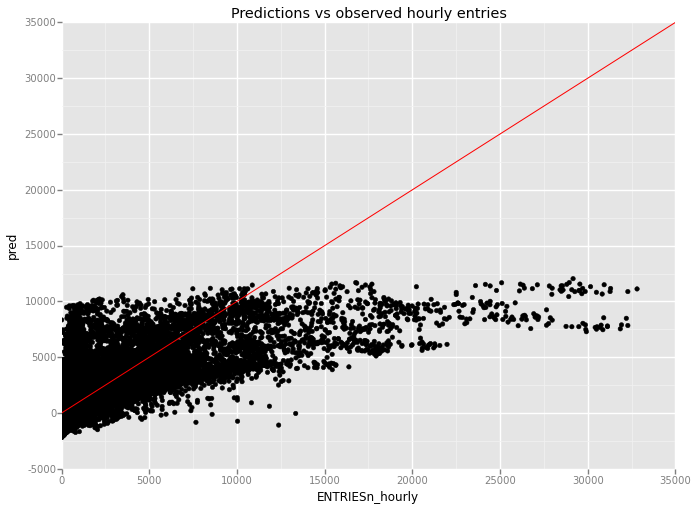

<ggplot: (288559357)>


In [60]:
plot = ggplot(aes(x='ENTRIESn_hourly',y='pred', asp=1),data=turnstile_weather) +\
        geom_point() +\
        geom_abline(intercept=0, slope=1, color='red') +\
        xlim(low=0,high=35000) + ylim(low=-5000,high=35000) +\
        ggtitle('Predictions vs observed hourly entries')
ggsave('predictions-vs-hourlyentries.png', plot)
print plot